In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [9]:
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

In [10]:
num_points = 100
# Index points should be a collection (100, here) of feature vectors. In this
# example, we're using 1-d vectors, so we just need to reshape the output from
# np.linspace, to give a shape of (100, 1).
index_points = np.expand_dims(np.linspace(-1., 1., num_points), -1)
print(index_points.shape)

# Define a kernel with default parameters.
# Use "squared exponential", "Gaussian" or "radial basis function"
kernel = psd_kernels.ExponentiatedQuadratic()

gp = tfd.GaussianProcess(kernel, index_points)

samples = gp.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`

(100, 1)


In [60]:
f = tf.Session().run(samples)
tf.Session().run(gp.stddev())

array([1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005, 1.0000005,
       1.0000005, 1.0000005, 1.0000005, 1.0000005, 

In [52]:
samples.

<tfp.distributions.Normal 'GaussianProcess/init/Normal/' batch_shape=() event_shape=() dtype=float64>

In [75]:
tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

# Generate noisy observations from a known function at some random points.
observation_noise_variance = .5
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = (f(observation_index_points) +
                np.random.normal(0., np.sqrt(observation_noise_variance)))

index_points = np.linspace(-1., 1., 100)[..., np.newaxis]

kernel = psd_kernels.MaternFiveHalves()

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`.

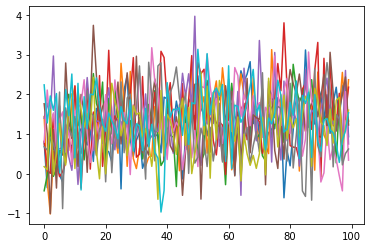

In [76]:
plt.plot(tf.Session().run(samples).T)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Step 0: NLL = 982.3549982723556
Step 100: NLL = -27.67981800840174
Step 200: NLL = -35.6148779400006
Step 300: NLL = -40.99514546920203
Step 400: NLL = -42.843859083861815
Step 500: NLL = -42.97387557944212
Step 600: NLL = -42.97438003854842
Step 700: NLL = -42.97438006624793
Step 800: NLL = -42.97438006624775
Step 900: NLL = -42.97438006624776
Final NLL = -42.97438006624783


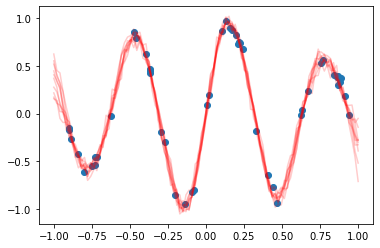

In [77]:
# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = f(observation_index_points) + np.random.normal(0., .05, 50)

# Define a kernel with trainable parameters. Note we transform the trainable
# variables to apply a positivity constraint.
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(0)), name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

observation_noise_variance = tf.exp(
    tf.Variable(np.float64(-5)), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)
neg_log_likelihood = -gp.log_prob(observations)

optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(neg_log_likelihood)

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the same parameters, which we'll optimize below).
index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`.

# Now execute the above ops in a Session, first training the model
# parameters, then drawing and plotting posterior samples.
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(1000):
    _, neg_log_likelihood_ = sess.run([optimize, neg_log_likelihood])
    if i % 100 == 0:
      print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

  print("Final NLL = {}".format(neg_log_likelihood_))
  samples_ = sess.run(samples)

  plt.scatter(np.squeeze(observation_index_points), observations)
  plt.plot(np.stack([index_points[:, 0]]*10).T, samples_.T, c='r', alpha=.2)
